In [1]:
# dependencies
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.utils.spectral_norm as spectral_norm
import torch.optim as optim
import torchvision
import itertools
from torchvision.models import vgg16
from torch.nn.functional import mse_loss
from torchvision import transforms
import numpy as np
import pandas as pd
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import shutil
import random

!pip install opendatasets
!pip install pandas
!pip install -q kaggle
import opendatasets as od

In [2]:
# Our Dataset Class for Loading Photos Data of two kinds - One folder containing Ukiyo-e style paintings
# for the GAN to learn from and the other containing ~7000 photos to apply the style to.

class photosdata(Dataset):
    def __init__(self, ukiyoe_folder, photos_folder, transform=None):
        self.ukiyoe_folder = ukiyoe_folder
        self.photos_folder = photos_folder
        self.transform = transform

        self.Ukiyoes = [os.path.join(ukiyoe_folder, f) for f in os.listdir(ukiyoe_folder) if f.endswith(('.png','.jpeg','.jpg'))]
        self.pictures = [os.path.join(photos_folder, f) for f in os.listdir(photos_folder) if f.endswith(('.png','.jpeg','.jpg'))]

    def __getitem__(self, idx):
        path_for_ukiyoe = self.Ukiyoes[idx % len(self.Ukiyoes)]
        path_for_photo = self.pictures[idx % len(self.pictures)]

        Ukiyoe = np.array(Image.open(path_for_ukiyoe).convert('RGB')).astype('float32')
        Picture = np.array(Image.open(path_for_photo).convert('RGB')).astype('float32')

        # applying transformation before returning the photos data
        if self.transform:
            augmnt = transform(image=Ukiyoe, image1=Picture)
            Ukiyoe = augmnt["image"]
            Picture = augmnt["image1"]

        return Ukiyoe, Picture

    def __len__(self):
        return max(len(self.Ukiyoes), len(self.pictures))

# Applying transformations to the pictures - Decided to go with the likes of GaussianBlur & RandomGamma

transform = A.Compose(
    [A.Rotate(limit=20, p=0.5),
        A.HorizontalFlip(),
        A.Resize(128, 128),
        A.RandomGamma(gamma_limit=(95, 105), p=0.5),
    A.GaussianBlur(blur_limit=(5, 5), p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2(),
    ], additional_targets={"image1": "image"},
)

# Tensors and Device
dvc = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

# Printing device information
print(f"Device: {dvc}")

torch.backends.cudnn.benchmark = True


Device: cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


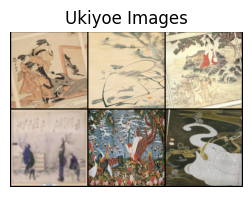

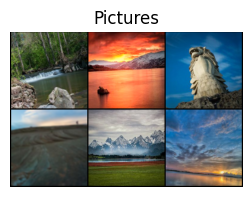

In [4]:
# Hyperparameters

num_epochs = 30
lr = 0.0002
img_size = 128
num_workers = 4
batch_size = 16
channels_img = 3

save_model = True
lambda_cycle = 8.0
lambda_identity = 3.0


checkpoint_disc_m = "discM.pth.tar"
checkpoint_disc_p = "discP.pth.tar"
checkpoint_gen_m = "genM.pth.tar"
checkpoint_gen_p = "genP.pth.tar"

train_dataset = photosdata("/content/drive/MyDrive/ukiyoetrain", "/content/drive/MyDrive/phototrain", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Visualizing the images after applying the transformation defined before
img_ukiyoe, img_photo = next(iter(train_loader))
def visualizer(img, rows=2, title=""):
    img = img.detach().cpu() * 0.5 + 0.5
    img_grid = torchvision.utils.make_grid(img, nrow=rows).permute(1, 2, 0)
    plt.figure(figsize=(3, 5))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

visualizer(img_ukiyoe[:6], rows=3, title="Ukiyoe Images")
visualizer(img_photo[:6], rows=3, title="Pictures")

In [5]:
# Building our generator model

class generator_block(nn.Module):
    def __init__(self, input_channels, output_channels, encoder=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, padding_mode="reflect", **kwargs) if encoder
            else nn.ConvTranspose2d(input_channels, output_channels, **kwargs),
            nn.InstanceNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class residual_block(nn.Module):
    def __init__(self, channels, dropout=False):
        super().__init__()
        layers = [
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, stride=1, padding_mode="reflect"),
            nn.ReLU(inplace=True),
            nn.InstanceNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, stride=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels)
        ]
        if dropout:
            layers.insert(3, nn.Dropout(0.5))
            # before the last convolution in the block (inserting dropout)

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels, num_features=64, num_residuals=6):
        super().__init__()
        # the first convolution block so as to process the input image
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        # encoder blocks (to downsample the feature maps)
        self.enc_blocks = nn.ModuleList([
            generator_block(num_features, num_features * 2, encoder=True, kernel_size=3, stride=2, padding=1),
            generator_block(num_features * 2, num_features * 4, encoder=True, kernel_size=3, stride=2, padding=1),
            # extra downsampling layer for deeper feature extraction
            generator_block(num_features * 4, num_features * 8, encoder=True, kernel_size=3, stride=2, padding=1),
        ])

        # dropout to residual blocks for regularization
        self.residual_blocks = nn.Sequential(
            *[residual_block(num_features * 8, dropout=True) for _ in range(num_residuals)]
        )

        # decoder blocks (upsampling)
        self.dec_blocks = nn.ModuleList([
            generator_block(num_features * 8, num_features * 4, encoder=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            # Adding an extra upsampling layer for symmetry with the encoder path
            generator_block(num_features * 4, num_features * 2, encoder=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            generator_block(num_features * 2, num_features, encoder=False, kernel_size=3, stride=2, padding=1, output_padding=1),
        ])

        self.last = nn.Sequential(
            nn.Conv2d(num_features, input_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.initial(x)
        for block in self.enc_blocks:
            x = block(x)
        x = self.residual_blocks(x)
        for block in self.dec_blocks:
            x = block(x)
        x = self.last(x)
        return x


def generator_testing():
    x = torch.randn((10, 3, 128, 128))
    gen = Generator(input_channels=3, num_residuals=6)
    image = gen(x)
    print(image.shape)

generator_testing()

# The output given by the generator "torch.Size([10, 3, 128, 128])" represents an image with
# three color channels - RGB - and a resolution of 128x128 pixels for each of the 10 samples in our batch.

torch.Size([10, 3, 128, 128])


In [6]:
# Building the discriminator model

class DiscBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=2):
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=4, stride=stride, padding=1, padding_mode="reflect"),nn.InstanceNorm2d(output_channels),nn.LeakyReLU(0.3),)

    def forward(self, x):
        return self.conv_block(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels, features=[64, 128, 256, 512]):
        super().__init__()

        # first convolutional layer w/o spectral normalization
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, features[0], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        layers = []
        in_channels = features[0]

        # adding spectral normalization to convolutional layers
        for feature in features[1:]:
            layers.append(
                nn.Sequential(
                    spectral_norm(nn.Conv2d(in_channels, feature, kernel_size=4, stride=2, padding=1)),
                    nn.InstanceNorm2d(feature),
                    nn.LeakyReLU(0.2, inplace=True)
                )
            )
            in_channels = feature

        # Adding additional convolutional layer for more depth
        layers.append(
            nn.Sequential(
                spectral_norm(nn.Conv2d(in_channels, in_channels*2, kernel_size=4, stride=1, padding=1)),
                nn.InstanceNorm2d(in_channels*2),
                nn.LeakyReLU(0.2, inplace=True)
            )
        )
        in_channels *= 2

        # Final convolutional layer mapping to a single output prediction-we need disc to give a single output
        self.final = spectral_norm(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.model(x)
        x = self.final(x)
        return torch.sigmoid(x)

# now we test if the discriminator is producing an output of expected shape
def disc_test():
    x = torch.randn((10, 3, 128, 128))
    disc = Discriminator(input_channels=3)
    output = disc(x)
    print(output.shape)

disc_test()

torch.Size([10, 1, 6, 6])


In [7]:
# Now we will try plotting losses
def plot(loss_gen, loss_disc):
    plt.figure(figsize=(8, 4))
    plt.title("Loss during training")
    plt.plot(loss_gen.detach().cpu().numpy(), label="Gen")
    plt.plot(loss_disc.detach().cpu().numpy(), label="Disc")
    plt.xlabel("No_of_Iter")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def advanced_plot(losses, title="Training Losses", xlabel="Iterations", ylabel="Loss", legend=None):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    for loss_values, label in zip(losses, legend or []):
        plt.plot(range(len(loss_values)), loss_values, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="upper right")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def save_checkpoint(model, optimizer, file_name = "my_checkpoint.pth.tar"):
    print("checkpoint is being saved...")

    checkpoint = {
        "state_dictionary": model.state_dict(),
        "optim": optimizer.state_dict(),
    }

    torch.save(checkpoint, file_name)

def advanced_save_checkpoint(model, optimizer, epoch, file_name="checkpoint.pth.tar", additional_info=None):
    print("Saving checkpoint to:", file_name)
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch
    }
    if additional_info is not None:
        checkpoint.update(additional_info)

    torch.save(checkpoint, file_name)

In [8]:
disc_P = Discriminator(input_channels=3).to(dvc)
disc_M = Discriminator(input_channels=3).to(dvc)
gen_P = Generator(input_channels=3, num_residuals=9).to(dvc)
gen_M = Generator(input_channels=3, num_residuals=9).to(dvc)

#optimizer initialization
opt_disc = optim.Adam(
    params=itertools.chain(disc_P.parameters(), disc_M.parameters()),
    lr=0.0002,
    betas=(0.6, 0.999)
)

opt_gen = optim.Adam(
    params=itertools.chain(gen_P.parameters(), gen_M.parameters()),
    lr=0.0002,  #symmetry between generator and disc's lr
    betas=(0.6, 0.999)  # keeping beta values consistent
)

L1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = vgg16(pretrained=True).features[:23].eval().to(dvc)
        for param in vgg.parameters():
            param.requires_grad_(False)
        self.vgg = vgg
        self.loss = mse_loss

    def forward(self, input, target):
        input_features = self.vgg(input)
        target_features = self.vgg(target)
        return self.loss(input_features, target_features)

decay_epoch = 20

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(num_epochs-decay_epoch)

lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(opt_disc, lr_lambda=lambda_func)
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(opt_gen, lr_lambda=lambda_func)

In [ ]:
# Training

scaler_disc = torch.cuda.amp.GradScaler()
scaler_gen = torch.cuda.amp.GradScaler()

#an optional addition : to be able to dynamically adjust training parameters:
# adjust_training_params = True

# subset_size = 1 : used for testing
subset_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

#
D_LOSS = []
G_LOSS = []
#num_epochs = 3: used for testing
for epoch in range(num_epochs):
    loop = tqdm(subset_train_loader, leave=True, desc=f"EPOCH {epoch + 1}/{num_epochs}")
    for idx, (m,p) in enumerate(loop):
        #if idx >= subset_size:  # Stop iterating if we reach the subset size
            #break
        #above two lines used for testing code with smaller data size

        m, p = m.to(dvc), p.to(dvc)

        #now proceeding with
        #training the disc

        with torch.cuda.amp.autocast():
            fake_m = gen_M(p)
            d_m_real = disc_M(m)
            d_m_fake = disc_M(fake_m.detach())
            d_m_real_loss = mse_loss(d_m_real, torch.ones_like(d_m_real))
            d_m_fake_loss = mse_loss(d_m_fake, torch.zeros_like(d_m_fake))
            d_m_loss = d_m_real_loss + d_m_fake_loss

            fake_p = gen_P(m)
            d_p_real = disc_P(p)
            d_p_fake = disc_P(fake_p.detach())
            d_p_real_loss = mse_loss(d_p_real, torch.ones_like(d_p_real))
            d_p_fake_loss = mse_loss(d_p_fake, torch.zeros_like(d_p_fake))
            d_p_loss = d_p_real_loss + d_p_fake_loss

            loss_disc = (d_m_loss + d_p_loss) / 2

        opt_disc.zero_grad()
        scaler_disc.scale(loss_disc).backward()
        scaler_disc.step(opt_disc)
        scaler_disc.update()

        #training the gen

        with torch.cuda.amp.autocast():
            # ukiyoe and photos - adv loss for both
            d_m_fake = disc_M(fake_m)
            d_p_fake = disc_P(fake_p)
            g_m_loss = mse_loss(d_m_fake, torch.ones_like(d_m_fake))
            g_p_loss = mse_loss(d_p_fake, torch.ones_like(d_p_fake))

            # Cycle Loss
            cycle_m = gen_P(fake_m)
            cycle_p = gen_M(fake_p)
            cycle_m_loss = L1_loss(m, cycle_m)
            cycle_p_loss = L1_loss(p, cycle_p)

            # for ensuring input image identity preservation through the generator
            identity_m = gen_M(m)
            identity_p = gen_P(p)
            identity_m_loss = L1_loss(m, identity_m)
            identity_p_loss = L1_loss(p, identity_p)

            # total loss
            loss_gen = (
                    g_m_loss
                    + g_p_loss
                    + cycle_m_loss * lambda_cycle
                    + cycle_p_loss * lambda_cycle
                    + identity_m_loss * lambda_identity
                    + identity_p_loss * lambda_identity
            )

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()
        # we can optionally adjust the training parameters based on our ongoing losses by the following:
        '''
        if adjust_training_params and epoch % 10 == 0 and idx == 0:
            adjust_learning_rate(opt_disc, epoch, num_epochs)
            adjust_learning_rate(opt_gen, epoch, num_epochs)
        '''

        D_LOSS.append(loss_disc.item())
        G_LOSS.append(loss_gen.item())

        if idx % 200 == 0 or idx == len(loop) - 1:
            loop.set_postfix(D_loss=loss_disc.item(), G_loss=loss_gen.item())

        #D_LOSS.append(loss_disc.item())
        #G_LOSS.append(loss_gen.item())

        if idx % 200 == 0 or idx == len(loop) - 1:
            loop.set_postfix(D_loss=loss_disc.item(), G_loss=loss_gen.item())

    ## we need to visualize and save checkpoint at the end of every epoch
    with torch.no_grad():
        visualizer(img=p[:5], rows=5, title="Pictures from dataset")
        fake_m=fake_m.type(torch.float64)
        visualizer(img=fake_m[:5], rows=5, title=f"Epoch {epoch+1} Generated Ukiyo-E")

    lr_scheduler_D.step()
    lr_scheduler_G.step()

    # --------------------------------------------------------------------------------------------------
    if save_model and epoch % 5 == 0:
        save_checkpoint(disc_M, opt_disc, file_name=checkpoint_disc_m)
        save_checkpoint(disc_P, opt_disc, file_name=checkpoint_disc_p)
        save_checkpoint(gen_M, opt_gen, file_name=checkpoint_gen_m)
        save_checkpoint(gen_P, opt_gen, file_name=checkpoint_gen_p)

/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
EPOCH 1/30:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
EPOCH 1/30:   1%|▏         | 1/70 [03:37<4:09:57, 217.36s/it, D_loss=0.538, G_loss=12]

In [ ]:
loss_gen_tensor = torch.tensor(G_LOSS)
loss_disc_tensor = torch.tensor(D_LOSS)
# plotting the losses
plot(loss_gen_tensor, loss_disc_tensor)


In [ ]:

generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = transforms.ToPILImage()

gen_M.eval()

data_dir = "/content/drive/MyDrive/phototrain"

files = [os.path.join(data_dir, name) for name in os.listdir(data_dir)]

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = generate_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)

    # generate
    fake_imgs = gen_M(imgs).detach().cpu()

    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)

        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(saving_directory, name))


In [ ]:
class img_folder_dataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path = self.files[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# transformations and dynamic resizing
generate_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # resizing for consistency
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
saving_directory = '/content/drive/MyDrive/savefiles' # ensuring it exists or creating it
os.makedirs(saving_directory, exist_ok=True)

to_image = transforms.ToPILImage()

gen_M.eval()

data_dir = "/content/drive/MyDrive/phototrain"
dataset = img_folder_dataset(data_dir, transform=generate_transforms)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for batch in data_loader:
    fake_imgs = gen_M(batch.to(dvc)).detach().cpu()
    for i, fake_img in enumerate(fake_imgs):
        img = to_image(fake_img).convert("RGB")
        img.save(os.path.join(saving_directory, f"generated_{i}.jpg"))

shutil.make_archive("/content/drive/MyDrive/savefiles", 'zip', "/content/drive/MyDrive/savefiles")
